In [1]:
# install vizdoom
!pip install vizdoom

In [2]:
#misc
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import matplotlib.pyplot as plt
# env
import gymnasium as gym
from vizdoom import gymnasium_wrapper
# learning
import torch
import torch.nn as nn
import torch.autograd as autograd
import torchvision.transforms as T
# google collab
from google.colab import files

# Setup for DQN

check for cuda

In [3]:
# Utilize GPU for training if GPU present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

Image preprocessing

In [4]:
transformer = T.Compose([
    T.ToPILImage(),
    T.Resize((50,75)),
    T.Grayscale(),
    T.ToTensor()
])
def preprocess(obs):
    # returns shape [C, H, W] where C = 1 because gray
    return transformer(obs["screen"]).squeeze(1).to(device)

We first need a **Transition** class which represents a `(state, action) -> (state', reward)` datapoint.

Then we need a **Replay Memory** class to store and utilize these transitions.

In [5]:
Transition = namedtuple(
    "Transition",
    ["obs", "next_obs", "action", "reward", "done"]
)

In [6]:
class ReplayBuffer(object):
    def __init__(self, buffer_size):
        # deque's FIFO structure will forget older memories as the agent explores
        self.memory = deque([], buffer_size)

    def __len__(self) -> int:
        return len(self.memory)

    def push(self, obs, next_obs, action, rew, done):
        """Save a transition"""
        t = Transition(preprocess(obs).clone().detach(),
                       preprocess(next_obs).clone().detach(),
                       int(action),
                       float(rew),
                       bool(done)
        )
        self.memory.append(t)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# DQN Class

In [7]:
class DQN(nn.Module):
    def __init__(self, n_actions) -> None:
        super(DQN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2),
            nn.ReLU()
        )

        dummy_input = torch.zeros(1, 1, 50, 75)  # [batch_size, in_channels, height, width]
        output = self.conv1(dummy_input)

        conv1_out_shape = output.view(output.size(0), -1).shape # output.size(0) = batch_size
        self.lin1 = nn.Sequential(
            nn.Linear(conv1_out_shape[1], 128),
            nn.ReLU()
        )

        self.lin2 = nn.Sequential(
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1) # x.size(0) = batch_size
        x = self.lin1(x)
        x = self.lin2(x)
        return x

We will add some boilerplate for the training, and some helper functions.

In [8]:
# Initialize RNG seed
seed:int = 42 #rng seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# HYPERPARAMETERS
total_timesteps:int = 500000 # timestep max of an experiment
lr:float = 0.0001
buffer_size:int = 10000 # experience replay buffer size
gamma: float = 0.99 # discount factor
batch_size: int = 128 # batch size for experience replay buffer sampling
epsilon_max: float = 1 # starting epsilon value (exploration/exploitation)
epsilon_min:float = 0.05 # ending epsilon value
epsilon_duration:float = 0.5 # time spent before min epsilon is reached
training_start:int = 10000 # steps needed before training begins
tnur: int = 1 # target network update rate
tnuf: int = 500 # target network update frequency
qntf: int = 10 # qnetwork training frequency

Epsilon decay let's us start by picking random actions, then slowly start picking actions that yield high rewards. We first explore a wide array of options, and once we have an idea of what works and what doesn't, we start exploiting that knowledge and ldive deeper.

In [9]:
def epsilon_decay(current_timestep: int):
    slope = (epsilon_min - epsilon_max) / total_timesteps
    return max(slope * current_timestep + epsilon_max, epsilon_min)

In [10]:
def get_action(action_space:gym.Space, obs, q_net:DQN, current_timestep:int):
    rng = random.random()
    epsilon = epsilon_decay(current_timestep)
    if rng > epsilon:
        # action with highest q_value
        q_values = q_net(obs.unsqueeze(0).to(device))
        action = torch.argmax(q_values).cpu().numpy()
    else:
        # random action
        action = action_space.sample()
    return action

Define model, optimizer, and replay buffer.

# Define environment

In [11]:
env:gym.Env = gym.make("VizdoomBasic-v0")

env: :gym.Env=gym.make("VizdoomBasic-v0")


In [13]:
env:gym.Env = gym.make("VizdoomBasic-v0")
# Initialize agent & target network
q_net = DQN(env.action_space.n).to(device)
optimizer = torch.optim.Adam(q_net.parameters(), lr)
# Target network is used to evaluate the progress of our DQN.
# It represents the past policy from which we evaluate surplus reward gains.
target_net = DQN(env.action_space.n).to(device)
target_net.load_state_dict(q_net.state_dict())

# Initialize Experience Replay (ER) buffer
# ER is used in DQN to avoid catastrophic forgetting.
# It allows the model to re-train on previous experiences in order to
# mix it with novel experiences and not forget previous training.
# Another benefit of ER is that by randomly sampling data from memory
# we avoid sequential correlation of experiences.
replay_buffer = ReplayBuffer(buffer_size)

/usr/local/lib/python3.11/dist-packages/vizdoom/gymnasium_wrapper/base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


We need to be able to read the memory, get a `batch_size` amount of transitions, and make that into a batch with tensors

In [14]:
def collate(batch) -> dict:
    batch_dict = {}
    batch_dict["obs"] = torch.stack([t.obs for t in batch]).to(device) # shape [B, C, H, W]
    batch_dict["next_obs"] = torch.stack([t.next_obs for t in batch]).to(device) # shape [B, C, H, W]
    batch_dict["action"] = torch.tensor([t.action for t in batch]).to(device) # shape [B]
    batch_dict["reward"] = torch.tensor([t.reward for t in batch]).to(device) # shape [B]
    batch_dict["done"] = torch.tensor([t.done for t in batch]).to(device) # shape [B]
    return batch_dict

Training Loop

In [15]:
def train(episode_losses):
    # create batch from memory
    batch = collate(replay_buffer.sample(batch_size))
    # get predictions in the form of q-values over all actions
    q_values = q_net(batch["obs"])
    # get the prediction of the action that was actually taken
    q_values_for_actions = q_values.gather(1, batch["action"].unsqueeze(1)).squeeze(1)
    # get the prediction of the target network
    target_net_max = target_net(batch["next_obs"]).max(dim=1)[0]
    # target q-values based on bellman equation
    q_target = batch["reward"] + gamma * target_net_max * (1 - batch["done"].float())
    # BACKPROP
    # compute loss
    loss = nn.functional.mse_loss(q_values_for_actions, q_target)
    episode_losses.append(loss.item())
    optimizer.zero_grad()
    # backprop
    loss.backward()
    optimizer.step()

In [17]:
obs, info = env.reset(seed=42)
episode_rewards = []
episode_losses = []
current_episode_reward = 0
for global_step in tqdm(range(total_timesteps)):
    # get action epsilon-greedy
    action = get_action(env.action_space, preprocess(obs), q_net, global_step)
    # step through the env
    next_obs, rew, term, trun, info = env.step(action)
    current_episode_reward += rew
    # store transition into memory
    replay_buffer.push(obs, next_obs, action, rew, term or trun) # term or trun = done
    # update obs
    obs = next_obs
    # env reset when finished
    if term or trun:
        obs, info = env.reset()
        episode_rewards.append(current_episode_reward)
        current_episode_reward = 0

    # TRAINING
    if global_step > training_start:
        if global_step % qntf == 0:
            train(episode_losses)
        if global_step % tnuf == 0:
            target_net.load_state_dict(q_net.state_dict())

    # periodically save model
    if global_step % 50000 == 0:
        torch.save(q_net.state_dict(), f"dqn_step_{global_step}.pth")  # works in Colab
        files.download(f"dqn_step_{global_step}.pth")
        # OR: move to CPU before saving to ensure portability
        torch.save(q_net.cpu().state_dict(), f"dqn_cpu_step_{global_step}.pth")
        files.download(f"dqn_cpu_step_{global_step}.pth")
        q_net.to(device)  # optionally move back to GPU after saving

env.close()

  0%|          | 0/500000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  1%|          | 4992/500000 [00:17<34:04, 242.16it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  2%|▏         | 9971/500000 [00:35<26:05, 312.97it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  2%|▏         | 10246/500000 [00:36<29:11, 279.58it/s]


KeyboardInterrupt: 

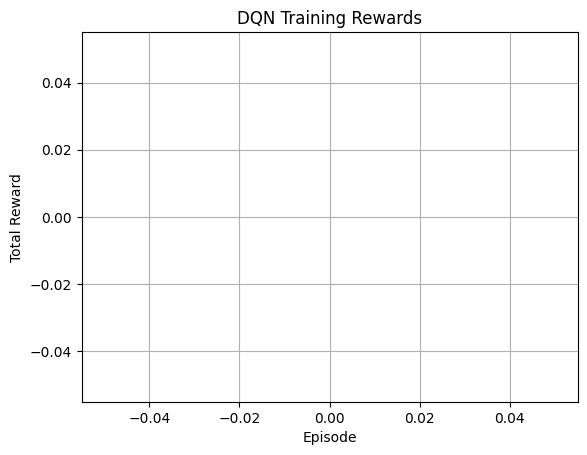

In [41]:
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Rewards")
plt.grid(True)
plt.show()

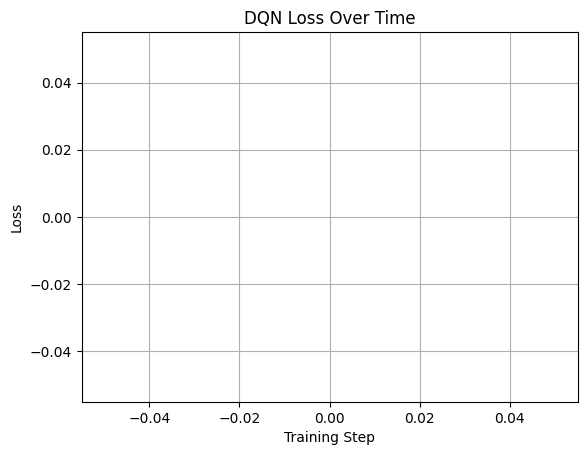

In [42]:
plt.plot(episode_losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("DQN Loss Over Time")
plt.grid(True)
plt.show()